# Visualization of H in a vertical crosssection

In [5]:
# import packages
import sys
import os.path

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## Needed functions

In [6]:
def height_to_pressure(z):
    """
    Convert height (m) to pressure (hPa) using standard atmosphere 
    conditions and the barometric formula.

    Parameters
    ----------
    z: float
        terrain elevation in m

    Returns
    -------
    p: float
        pressure at terrain height in hPa
    """
    
    p0 = 1013.25  # standard pressure (hPa)
    T0 = 288.15   # standard temperature (K)
    g = 9.81   # gravitational constant
    R = 287.05   # specific gas constant (J kg^-1 K^-1)
    L = 0.0065    # temperature lapse rate (K/m)

    p = p0 * (1 - L * z / T0) ** (g / (R * L))   # barometric formula

    return p

In [7]:
def add_color_code(ds):
    """
    Add a variable to the dataset that indicates the flow situation 
    based on H with colors. Red is blocked flow, green is flow over 
    and blue is uneffected flow.

    Parameters
    ----------
    ds: dataset
        dataset containing all variables
    """
    
    ds['H_color'] = xr.where(ds['H'] > 1, 'red', 'green') # H > 1 blocked, H <=1 flow around
    ds['H_color'] = xr.where(np.isnan(ds['H']), 'black', ds['H_color'])  # filter NaNs
    ds['H_color'] = xr.where(ds['perpendicular_wind_speed'] == 0, 'blue', ds['H_color']) # unaffected flow

In [8]:
def select_data(ds, lon, start_lat=45.5, end_lat=47.8):
    """
    Select wanted area for a vertical cross section 
    from the dataset.

    Parameters
    ----------
    ds: dataset
        dataset containing all variables
    lon: float 
        longitude of the N-S oriented crosssection
    start_lat: float
        start latitude of the vertical crosssection
    end_lat: float
        end latitude of the vertical crosssection

    Returns
    -------
    ds_crosssec: dataset
        dataset containing all variables along the given longitude
    """ 
    
    ds_crosssec = ds.sel(longitude=lon, method='nearest').sel(valid_time='2025-09-02T12:00:00') 
    ds_crosssec = ds_crosssec.sel(latitude=slice(end_lat, start_lat))

    return ds_crosssec

In [9]:
def apply_terrain_mask(ds_crosssec):
    """
    Apply a terrain mask to H, 
    so gridpoints beneath the terrain are not plotted.

    Parameters
    ----------
    ds_crosssec: dataset
        dataset containing all variables along the given longitude

    Returns
    -------
    H_masked: dataarray
        dataarray of H with gridpoints inside the terrain are NaNs
    H_color_masked: dataarray
        dataarray of H_color with gridpoints inside the terrain are NaNs
    """
    
    p = ds_crosssec.pressure_level
    lat = ds_crosssec.latitude
    
    p2d, _ = xr.broadcast(p, lat)
    terrain_p2d, _ = xr.broadcast(terrain_p, p)
    
    H_masked = ds_crosssec['H'].where(p2d < terrain_p2d)
    H_color_masked = ds_crosssec['H_color'].where(p2d < terrain_p2d)

    return H_masked, H_color_masked

In [12]:
def vertical_crosssection(terrain_p, H_masked, H_color_masked):
    """
    Create a vertical crosssection of H including the terrain. 
    H is colorcoded for the different flow possibilites.

    Parameters
    ----------
    ds_crosssec: dataset
        dataset containing all variables along the given longitude

    Returns
    -------
    H_masked: dataarray
        dataarray of H with gridpoints inside the terrain are NaNs
    H_color_masked: dataarray
        dataarray of H_color with gridpoints inside the terrain are NaNs
    """
    
    # create color map
    color_map = {
        'red': 'red',
        'green': 'green',
        'blue': 'blue',
        'black': 'black'
    }

    mapper = np.vectorize(lambda x: color_map.get(x, 'lightgrey')) 
    colors = xr.apply_ufunc(mapper, H_color_masked.fillna('lightgrey'), 
                            dask='allowed' )

    # meshgrid
    lat, p = np.meshgrid(H_masked.latitude, H_masked.pressure_level)

    # create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # plot terrain
    ax.plot(terrain_p.latitude, terrain_p, color='black')
    ax.fill_between(terrain_p.latitude, terrain_p, y2=terrain_p.values.max(), color='lightgrey')
    ax.invert_yaxis() # pressure decreases with height

    # scatter plot H
    ax.scatter(lat.ravel(), p.ravel(), c=colors.values.ravel(), s=10)

    # add lables, title and grid
    ax.set_xlabel('latitude')
    ax.set_ylabel('pressure [hpa]')
    ax.set_title('Non-dimensional mountain height')
    ax.grid(alpha=0.4)

    # add legend
    legend_elements = [
    Patch(facecolor='red',   label='blocked / flow around'),
    Patch(facecolor='green', label='flow over'),
    Patch(facecolor='blue',  label='unaffected flow'),
    ]

    ax.legend(handles=legend_elements, loc='lower right')
    plt.show()

## Main

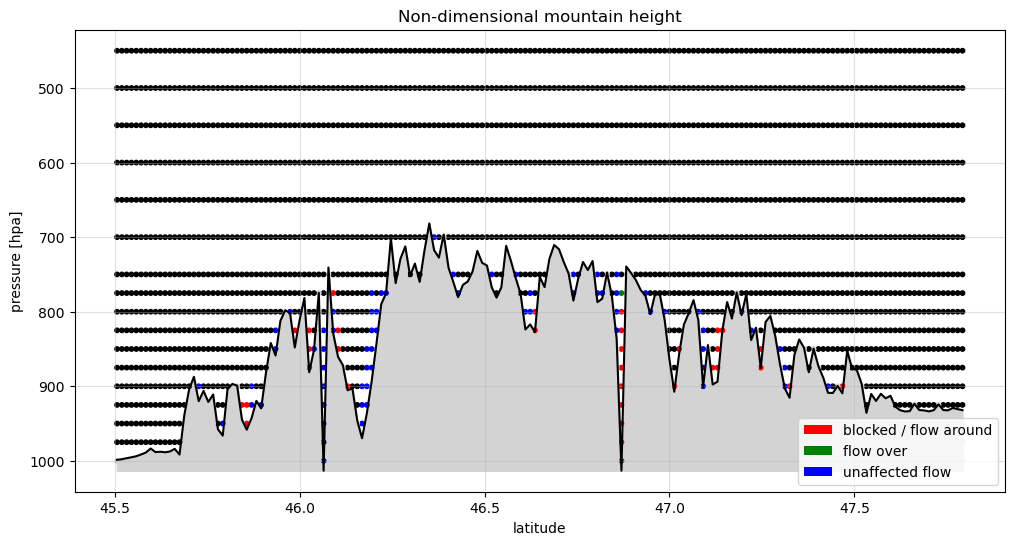

In [13]:
ds = xr.open_dataset('data/era5_test_with_NH.nc')
add_color_code(ds)

ds_crosssec = select_data(ds, 10)
terrain_p = height_to_pressure(ds_crosssec['terrain_elevation'])
H_masked, H_color_masked = apply_terrain_mask(ds_crosssec)

vertical_crosssection(terrain_p, H_masked, H_color_masked)